<a href="https://colab.research.google.com/github/AsutoshDalei/Deep-Neural-Networks/blob/master/GenerateSketches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip3 install torchinfo --quiet

# Generate Sketches

Humans have used sketching to depict our visual world since prehistoric times. Even today, sketching is possibly the only rendering technique readily available to all humans. This paper is the first large scale exploration of human sketches. We analyze the distribution of non-expert sketches of everyday objects such as 'teapot' or 'car'. We ask humans to sketch objects of a given category and gather 20,000 unique sketches evenly distributed over 250 object categories.

https://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/

In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.transforms import v2
from torchvision.io import read_image

## Data Collection
Fetcing and unzipping

In [3]:
# !wget https://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/sketches_png.zip
# !unzip /content/sketches_png.zip

In [4]:
dataPath = "/content/png"
dataPath = r"C:\Users\asuto\Desktop\Work\sketches_png\png"

numImgs,sktName = [],[]

hmap = {"fileName":[],'object':[]}

for ele in os.listdir(dataPath):
  if os.path.isdir(f"{dataPath}/{ele}"):
    # print(f"{ele} is a dir")
    numClassImg = len(os.listdir(f"{dataPath}/{ele}"))
    numImgs.append(numClassImg)
    sktName.append(ele)

    hmap['fileName'].extend(os.listdir(f"{dataPath}/{ele}"))
    hmap['object'].extend([ele]*len(os.listdir(f"{dataPath}/{ele}")))
    # hmap['path'].extend()

  else:
    print(f"{ele} is a file")

print(f"Number of objects sketched: {len(numImgs)}")

print(f"Average number of images per object: {sum(numImgs)/len(numImgs)}")

filelist.txt is a file
Number of objects sketched: 250
Average number of images per object: 80.0


In [5]:
%%time
data = pd.DataFrame(hmap)
data = data.assign(path = data.apply(lambda row: f"{dataPath}/{row['object']}/{row['fileName']}",axis=1))
data.head()

CPU times: total: 141 ms
Wall time: 149 ms


,fileName,object,path
0,1.png,airplane,C:\Users\asuto\Desktop\Work\sketches_png\png/a...
1,10.png,airplane,C:\Users\asuto\Desktop\Work\sketches_png\png/a...
2,11.png,airplane,C:\Users\asuto\Desktop\Work\sketches_png\png/a...
3,12.png,airplane,C:\Users\asuto\Desktop\Work\sketches_png\png/a...
4,13.png,airplane,C:\Users\asuto\Desktop\Work\sketches_png\png/a...


---
### Viewing Sketches

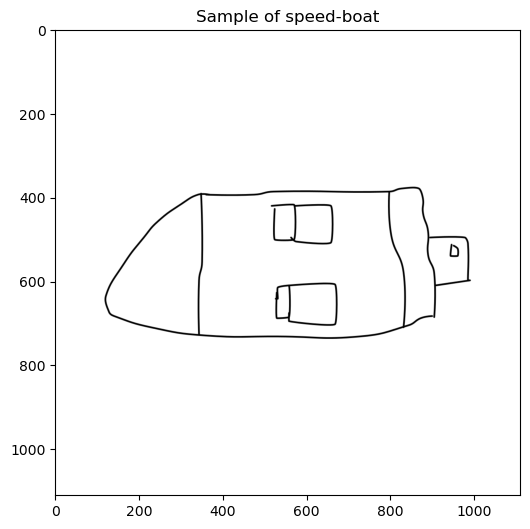

In [6]:
sample = data.sample(1)

def showSketch_init(sample):
  plt.figure(figsize=(6,7),dpi=100)
  img = plt.imread(sample['path'].item())
  imgplot = plt.imshow(img, cmap="gray")
  plt.title(f"Sample of {sample['object'].item()}")
  plt.show()

showSketch_init(sample)

In [7]:
img = plt.imread(sample['path'].item())
print(img.shape)
img

(1111, 1111)


array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

## Model Plan
* The idea is to take in one of the objects as an input and generate a sketch which corresponds to the object. Since we have 250 object classes, our input to the model would be an array of size 250. Each object would be represented by a combination of the input array.

* The output of the model would be the image. In this case, an array of (1111,1111).

### PyTorch Dataset & Transformers

In [8]:
transformFnx = v2.Compose([v2.ToImage(),
                           v2.RandomHorizontalFlip(0.5),
                           v2.ToDtype(torch.float32, scale=True)])

In [9]:
class datasetGen(Dataset):
  def __init__(self,data,transforms=None):
    self.data = data
    self.transforms = transforms

    nunq = data.object.nunique()
    self.inpMap, ptr = {}, 0
    for obj in sorted(data.object.unique()):
      self.inpMap[obj] = [0]*nunq
      self.inpMap[obj][ptr] = 1
      ptr+=1

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    row = self.data.iloc[idx]
    input = self.inpMap[row['object']]
    sketch = read_image(row['path'])

    if self.transforms:
      sketch = self.transforms(sketch)

    return input, sketch
      
gen = datasetGen(data=data, transforms=transformFnx)
iterGen = iter(gen)

In [10]:
sample

,fileName,object,path
15869,15870.png,speed-boat,C:\Users\asuto\Desktop\Work\sketches_png\png/s...


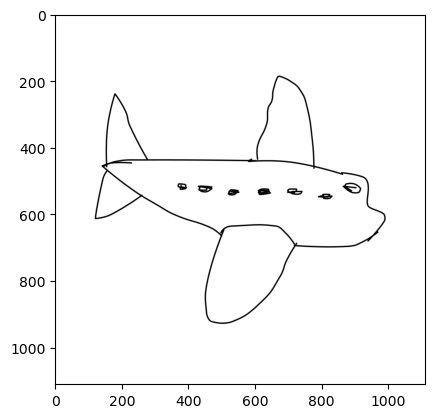

In [11]:
_, op = next(iterGen)
plt.imshow(op.reshape(1111,1111,1),cmap='gray')
plt.show()

In [12]:
%%time
print("Initial Data Length:",data.shape[0])
trainvalData, testData = train_test_split(data,test_size=0.2,stratify=data['object'])
print(f"TrainVal Split: {trainvalData.shape[0]} ({(trainvalData.shape[0]/data.shape[0])*100:.2g}%), Test Split: {testData.shape[0]} ({(testData.shape[0]/data.shape[0])*100:.2g}%)")

trainData, valData = train_test_split(trainvalData,test_size=0.3,stratify=trainvalData['object'])
print(f"Train Split: {trainData.shape[0]} ({(trainData.shape[0]/data.shape[0])*100:.2g}%), Val Split: {valData.shape[0]} ({(valData.shape[0]/data.shape[0])*100:.2g}%)")

Initial Data Length: 20000
TrainVal Split: 16000 (80%), Test Split: 4000 (20%)
Train Split: 11200 (56%), Val Split: 4800 (24%)
CPU times: total: 31.2 ms
Wall time: 47.5 ms


In [13]:
%%time
batch_size = 32

dataLoad_train = DataLoader(trainData,batch_size=batch_size,shuffle=True)
dataLoad_val = DataLoader(valData,batch_size=batch_size,shuffle=True)
dataLoad_test = DataLoader(testData,batch_size=batch_size,shuffle=True)

CPU times: total: 0 ns
Wall time: 0 ns


### Model Creation

In [64]:
class sketchModel(nn.Module):
    def __init__(self):
        super(sketchModel, self).__init__()

        self.features = nn.Sequential(
            #Layer 1
            nn.Linear(in_features=250, out_features=500),
            nn.ReLU(inplace=True),

            #Layer 2
            nn.Linear(500, 1000),
            nn.ReLU(inplace=True)
            
        )